In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
%matplotlib notebook
%matplotlib inline
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
batch_size = 100

train_data = datasets.FashionMNIST(root='fashiondata/',
                                   transform=transforms.ToTensor(),
                                   train=True,
                                   download=True)

train_samples = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                            shuffle=True)


In [0]:
class Discriminator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 4, stride = 2, padding = 1) #Want to take 28*28*1 into 64*14*14, decreases it by a half
    self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) #64*14*14 into 128*7*7
    self.dense1 = torch.nn.Linear(128*7*7, 1)
    
    self.bn1 = torch.nn.BatchNorm2d(64)
    self.bn2 = torch.nn.BatchNorm2d(128)
    
  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x))).view(-1,128*7*7) #Change size so each row is 128*7*7 and let there be however many rows (reshape into 1 long vector) 
    x = F.sigmoid(self.dense1(x))
    
    return x

In [0]:
class Generator(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.dense1 = torch.nn.Linear(128, 256)
    self.dense2 = torch.nn.Linear(256, 1024)
    self.dense3 = torch.nn.Linear(1024, 128*7*7) #Flat vector of size 128*7*7
    #Reverse of standard convolution (upsamples rather than downsamples)
    self.uconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) #128*7*7 into 64*14*14
    self.uconv2 = torch.nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1) #64*14*14 into 1*28*28
    
    self.bn1 = torch.nn.BatchNorm1d(256)
    self.bn2 = torch.nn.BatchNorm1d(1024)
    self.bn3 = torch.nn.BatchNorm1d(128*7*7)
    self.bn4 = torch.nn.BatchNorm2d(64)
    
  def forward(self, x):
    x = F.relu(self.bn1(self.dense1(x)))
    x = F.relu(self.bn2(self.dense2(x)))
    x = F.relu(self.bn3(self.dense3(x))).view(-1, 128, 7, 7) #Make it into this shape of 128*7*7, -1 because many images can be passed at once
    
    x = F.relu(self.bn4(self.uconv1(x)))
    x = F.sigmoid(self.uconv2(x))
    
    return x
    

In [0]:
d = Discriminator().cuda()
g = Generator().cuda()

epochs = 100
dlr = 0.0003
glr = 0.0003

d_optimiser = torch.optim.Adam(d.parameters(),lr = dlr)
g_optimiser = torch.optim.Adam(g.parameters(),lr = glr)

dcosts = []
gcosts = []

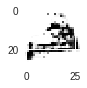

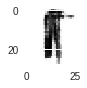

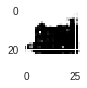

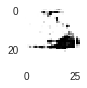

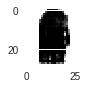

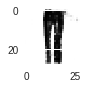

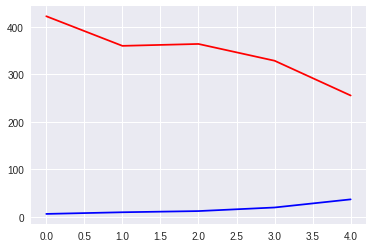

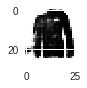

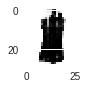

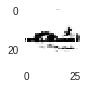

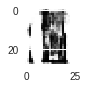

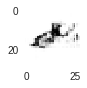

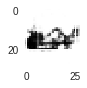

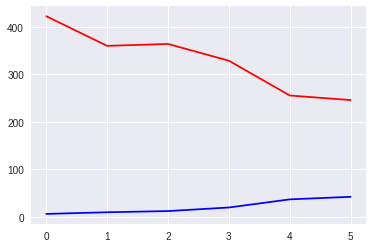

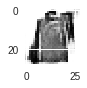

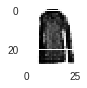

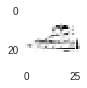

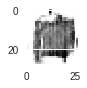

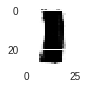

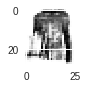

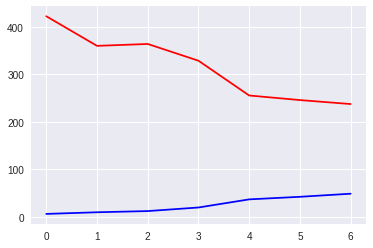

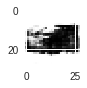

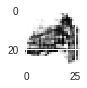

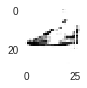

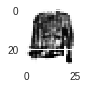

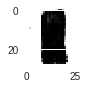

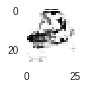

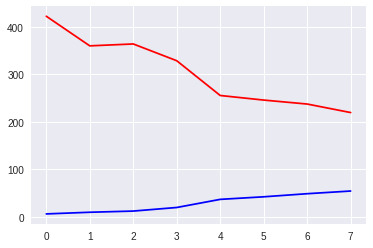

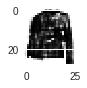

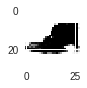

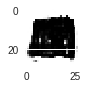

In [0]:
def train(epochs):
  for epoch in range(epochs):
    epochdcost = 0
    epochgcost = 0
    
    for k, (real_images, y) in enumerate(train_samples): #Index of batch, rea;_images = features, y =labels but labels is irrelevant
      real_images = Variable(real_images).cuda()
      
      z = Variable(torch.randn(batch_size, 128)).cuda() #First layer has 128 inputs in generator
      
      generated_images = g.forward(z)
      
      gen_pred = d.forward(generated_images)
      real_pred = d.forward(real_images)
      
      dcost = torch.sum(-torch.log(real_pred)) - torch.sum(torch.log(1-gen_pred)) #Trying to predict a 1 for real so log gives 0 (therefore no extra cost) whereas small for fake gives big when logged
      gcost = -torch.sum(torch.log(gen_pred)) #Think about these as they approach 1 and 0, they make sense
      
      d_optimiser.zero_grad()
      dcost.backward(retain_graph = True) #Need to put in retain_graph because we need to back propagate once for discriminator and once for generator
      d_optimiser.step()
      
      g_optimiser.zero_grad()
      gcost.backward()
      g_optimiser.step()
      
      epochdcost += dcost.data[0]
      epochgcost += gcost.data[0]
      
      if k*batch_size%10000 == 0: #k*batch_size = number of images
        g.eval()
        z = Variable(torch.randn(1,128)).cuda()
        generated_image = g.forward(z)
        
        plt.figure(figsize=(1, 1))
        plt.imshow(generated_image.data[0][0], cmap='gray_r')
        plt.show()
        
        g.train()
        
    epochdcost /= 60000/batch_size
    epochgcost /= 60000/batch_size
      
    dcosts.append(epochdcost)
    gcosts.append(epochgcost)
      
    plt.figure()
    plt.plot(dcosts, 'b')
    plt.plot(gcosts, 'r')
    plt.show()

      
train(epochs)
      